## Unsupervised Learning

The tasks in this notebook will focus on discrimination of Sea ice and lead based on altimetry data classification based on Sentinel-3 altimetry data.

Both will be done using Gaussian Mixure Models (GMM), a probabilistic model for representing normally distributed subpopulations within an overall population.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install netCDF4

In [3]:
# First import necessary packages
from sklearn.cluster import KMeans
from netCDF4 import Dataset
from scipy.interpolate import griddata
import numpy.ma as ma
import glob
from matplotlib.patches import Polygon
import scipy.spatial as spatial
from scipy.spatial import KDTree
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import linkage, fcluster
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt


## Altimetry Classification using Sentinel-3
Now, let's explore the application of unsupervised methods to altimetry classification tasks, focusing specifically on distinguishing between sea ice and leads in Sentinel-3 altimetry dataset.

### Read in Functions Needed
Before delving into the modeling process, it's crucial to preprocess the data to ensure compatibility with our analytical models. This involves transforming the raw data into meaningful variables, such as peakniness and stack standard deviation (SSD), etc.

In [4]:
# This cell is for preprocessing to ensure data is compatible with our analytical models

#=========================================================================================================
#===================================  SUBFUNCTIONS  ======================================================
#=========================================================================================================

#*args and **kwargs allow you to pass an unspecified number of arguments to a function,
#so when writing the function definition, you do not need to know how many arguments will be passed to your function
#**kwargs allows you to pass keyworded variable length of arguments to a function.
#You should use **kwargs if you want to handle named arguments in a function.
#double star allows us to pass through keyword arguments (and any number of them).
def peakiness(waves, **kwargs):

    "finds peakiness of waveforms."

    #print("Beginning peakiness")
    # Kwargs are:
    #          wf_plots. specify a number n: wf_plots=n, to show the first n waveform plots. \

    import numpy as np
    import matplotlib
    import matplotlib.pyplot as plt
    import time

    print("Running peakiness function...")

    size=np.shape(waves)[0] #.shape property is a tuple of length .ndim containing the length of each dimensions
                            #Tuple of array dimensions.

    waves1=np.copy(waves)

    if waves1.ndim == 1: #number of array dimensions
        print('only one waveform in file')
        waves2=waves1.reshape(1,np.size(waves1)) #numpy.reshape(a, newshape, order='C'), a=array to be reshaped
        waves1=waves2

    # *args is used to send a non-keyworded variable length argument list to the function
    def by_row(waves, *args):
        "calculate peakiness for each waveform"
        maximum=np.nanmax(waves)
        if maximum > 0:

            maximum_bin=np.where(waves==maximum)
            #print(maximum_bin)
            maximum_bin=maximum_bin[0][0]
            waves_128=waves[maximum_bin-50:maximum_bin+78]

            waves=waves_128

            noise_floor=np.nanmean(waves[10:20])
            where_above_nf=np.where(waves > noise_floor)

            if np.shape(where_above_nf)[1] > 0:
                maximum=np.nanmax(waves[where_above_nf])
                total=np.sum(waves[where_above_nf])
                mean=np.nanmean(waves[where_above_nf])
                peaky=maximum/mean

            else:
                peaky = np.nan
                maximum = np.nan
                total = np.nan

        else:
            peaky = np.nan
            maximum = np.nan
            total = np.nan

        if 'maxs' in args:
            return maximum
        if 'totals' in args:
            return total
        if 'peaky' in args:
            return peaky

    peaky=np.apply_along_axis(by_row, 1, waves1, 'peaky') #numpy.apply_along_axis(func1d, axis, arr, *args, **kwargs)

    if 'wf_plots' in kwargs:
        maximums=np.apply_along_axis(by_row, 1, waves1, 'maxs')
        totals=np.apply_along_axis(by_row, 1, waves1, 'totals')

        for i in range(0,kwargs['wf_plots']):
            if i == 0:
                print("Plotting first "+str(kwargs['wf_plots'])+" waveforms")

            plt.plot(waves1[i,:])#, a, col[i],label=label[i])
            plt.axhline(maximums[i], color='green')
            plt.axvline(10, color='r')
            plt.axvline(19, color='r')
            plt.xlabel('Bin (of 256)')
            plt.ylabel('Power')
            plt.text(5,maximums[i],"maximum="+str(maximums[i]))
            plt.text(5,maximums[i]-2500,"total="+str(totals[i]))
            plt.text(5,maximums[i]-5000,"peakiness="+str(peaky[i]))
            plt.title('waveform '+str(i)+' of '+str(size)+'\n. Noise floor average taken between red lines.')
            plt.show()


    return peaky

#=========================================================================================================
#=========================================================================================================
#=========================================================================================================


def unpack_gpod(variable):

    from scipy.interpolate import interp1d

    time_1hz=SAR_data.variables['time_01'][:]
    time_20hz=SAR_data.variables['time_20_ku'][:]
    time_20hzC = SAR_data.variables['time_20_c'][:]

    out=(SAR_data.variables[variable][:]).astype(float)  # convert from integer array to float.

    #if ma.is_masked(dataset.variables[variable][:]) == True:
    #print(variable,'is masked. Removing mask and replacing masked values with nan')
    out=np.ma.filled(out, np.nan)

    if len(out)==len(time_1hz):

        print(variable,'is 1hz. Expanding to 20hz...')
        out = interp1d(time_1hz,out,fill_value="extrapolate")(time_20hz)

    if len(out)==len(time_20hzC):
        print(variable, 'is c band, expanding to 20hz ku band dimension')
        out = interp1d(time_20hzC,out,fill_value="extrapolate")(time_20hz)
    return out


#=========================================================================================================
#=========================================================================================================
#=========================================================================================================

def calculate_SSD(RIP):

    from scipy.optimize import curve_fit
    # from scipy import asarray as ar,exp
    from numpy import asarray as ar, exp

    do_plot='Off'

    def gaussian(x,a,x0,sigma):
            return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

    SSD=np.zeros(np.shape(RIP)[0])*np.nan
    x=np.arange(np.shape(RIP)[1])

    for i in range(np.shape(RIP)[0]):

        y=np.copy(RIP[i])
        y[(np.isnan(y)==True)]=0

        if 'popt' in locals():
            del(popt,pcov)

        SSD_calc=0.5*(np.sum(y**2)*np.sum(y**2)/np.sum(y**4))
        #print('SSD calculated from equation',SSD)

        #n = len(x)
        mean_est = sum(x * y) / sum(y)
        sigma_est = np.sqrt(sum(y * (x - mean_est)**2) / sum(y))
        #print('est. mean',mean,'est. sigma',sigma_est)

        try:
            popt,pcov = curve_fit(gaussian, x, y, p0=[max(y), mean_est, sigma_est],maxfev=10000)
        except RuntimeError as e:
            print("Gaussian SSD curve-fit error: "+str(e))
            #plt.plot(y)
            #plt.show()

        except TypeError as t:
            print("Gaussian SSD curve-fit error: "+str(t))

        if do_plot=='ON':

            plt.plot(x,y)
            plt.plot(x,gaussian(x,*popt),'ro:',label='fit')
            plt.axvline(popt[1])
            plt.axvspan(popt[1]-popt[2], popt[1]+popt[2], alpha=0.15, color='Navy')
            plt.show()

            print('popt',popt)
            print('curve fit SSD',popt[2])

        if 'popt' in locals():
            SSD[i]=abs(popt[2])


    return SSD


In [5]:
# Import Sentinel 3A dataset
path = '/content/drive/MyDrive/AI4EO/Week_4/'
SAR_file = 'S3A_SR_2_LAN_SI_20190307T005808_20190307T012503_20230527T225016_1614_042_131______LN3_R_NT_005.SEN3'
SAR_data = Dataset(path + SAR_file + '/enhanced_measurement.nc')

SAR_lat = unpack_gpod('lat_20_ku')
SAR_lon = unpack_gpod('lon_20_ku')
waves   = unpack_gpod('waveform_20_ku')
sig_0   = unpack_gpod('sig0_water_20_ku')
RIP     = unpack_gpod('rip_20_ku')
flag = unpack_gpod('surf_type_class_20_ku')

# Filter out bad data points using criteria (here, lat >= -99999)
find = np.where(SAR_lat >= -99999)
SAR_lat = SAR_lat[find]
SAR_lon = SAR_lon[find]
waves   = waves[find]
sig_0   = sig_0[find]
RIP     = RIP[find]

# Calculate additional features
PP = peakiness(waves)
SSD = calculate_SSD(RIP)

# Convert to numpy arrays (if not already)
sig_0_np = np.array(sig_0)
PP_np    = np.array(PP)
SSD_np   = np.array(SSD)

# Create data matrix
data = np.column_stack((sig_0_np, PP_np, SSD_np))

# Standardize the data
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data)

Running peakiness function...


<ipython-input-4-221839a627ca>:50: RuntimeWarning: Mean of empty slice
  noise_floor=np.nanmean(waves[10:20])


Gaussian SSD curve-fit error: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Gaussian SSD curve-fit error: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Gaussian SSD curve-fit error: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


There are some NaN values in the dataset so one way to deal with this is to delete them.

In [6]:
# Remove any rows that contain NaN values
nan_count = np.isnan(data_normalized).sum()
print(f"Number of NaN values in the array: {nan_count}")

data_cleaned = data_normalized[~np.isnan(data_normalized).any(axis=1)]

mask = ~np.isnan(data_normalized).any(axis=1)
waves_cleaned = np.array(waves)[mask]
flag_cleaned = np.array(flag)[mask]

data_cleaned = data_cleaned[(flag_cleaned==1)|(flag_cleaned==2)]
waves_cleaned = waves_cleaned[(flag_cleaned==1)|(flag_cleaned==2)]
flag_cleaned = flag_cleaned[(flag_cleaned==1)|(flag_cleaned==2)]


Number of NaN values in the array: 1283


Now, let's proceed with running the GMM model as usual. Remember, you have the flexibility to substitute this with K-Means or any other preferred model.

In [7]:
gmm = GaussianMixture(n_components=2, random_state=0)
gmm.fit(data_cleaned)
clusters_gmm = gmm.predict(data_cleaned)

We can also inspect how many data points are there in each class of your clustering prediction.

In [8]:
unique, counts = np.unique(clusters_gmm, return_counts=True)
class_counts = dict(zip(unique, counts))
print("Cluster counts:", class_counts)

Cluster counts: {0: 8880, 1: 3315}


We can plot the mean waveform of each class.

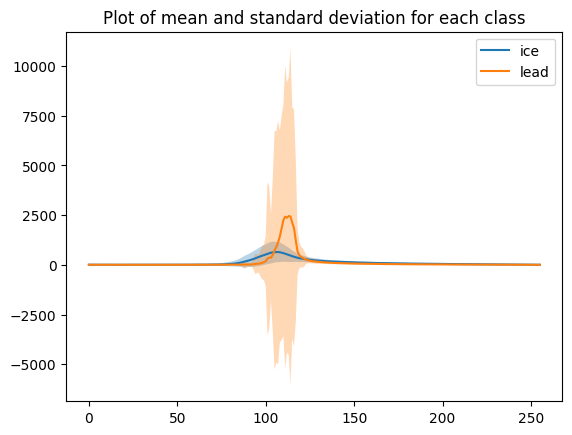

In [9]:
# mean and standard deviation for all echoes
mean_ice = np.mean(waves_cleaned[clusters_gmm==0],axis=0)
std_ice = np.std(waves_cleaned[clusters_gmm==0], axis=0)

plt.plot(mean_ice, label='ice')
plt.fill_between(range(len(mean_ice)), mean_ice - std_ice, mean_ice + std_ice, alpha=0.3)


mean_lead = np.mean(waves_cleaned[clusters_gmm==1],axis=0)
std_lead = np.std(waves_cleaned[clusters_gmm==1], axis=0)

plt.plot(mean_lead, label='lead')
plt.fill_between(range(len(mean_lead)), mean_lead - std_lead, mean_lead + std_lead, alpha=0.3)

plt.title('Plot of mean and standard deviation for each class')
plt.legend()

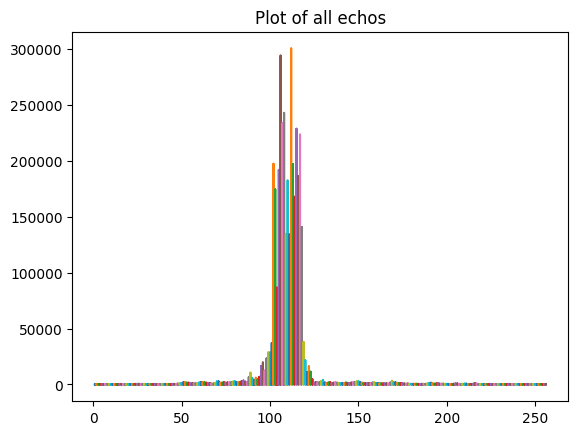

In [10]:
x = np.stack([np.arange(1,waves_cleaned.shape[1]+1)]*waves_cleaned.shape[0])
plt.plot(x,waves_cleaned)  # plot of all the echos
plt.title('Plot of all echos')
plt.show()

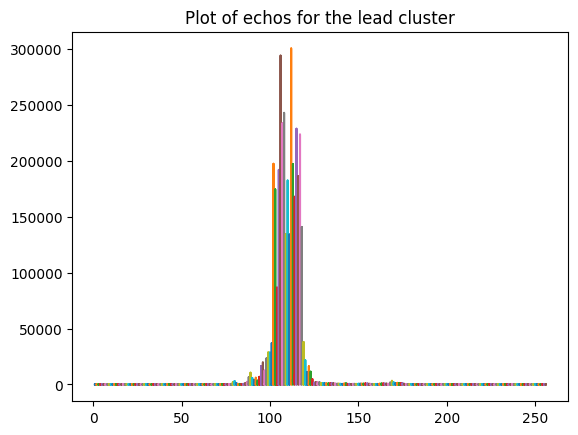

In [11]:
# plot echos for the lead cluster
x = np.stack([np.arange(1,waves_cleaned[clusters_gmm==1].shape[1]+1)]*waves_cleaned[clusters_gmm==1].shape[0])
plt.plot(x,waves_cleaned[clusters_gmm==1])  # plot of all the echos
plt.title('Plot of echos for the lead cluster')
plt.show()

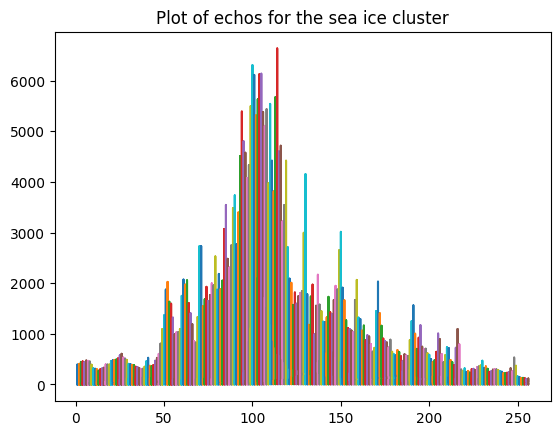

In [12]:
# plot echos for the sea ice cluster
x = np.stack([np.arange(1,waves_cleaned[clusters_gmm==0].shape[1]+1)]*waves_cleaned[clusters_gmm==0].shape[0])
plt.plot(x,waves_cleaned[clusters_gmm==0])  # plot of all the echos
plt.title('Plot of echos for the sea ice cluster')
plt.show()

## Scatter Plots of Clustered Data

This code visualizes the clustering results using scatter plots, where different colors represent different clusters (`clusters_gmm`).

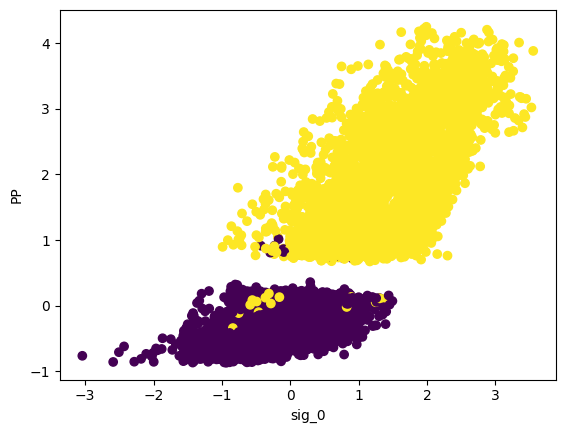

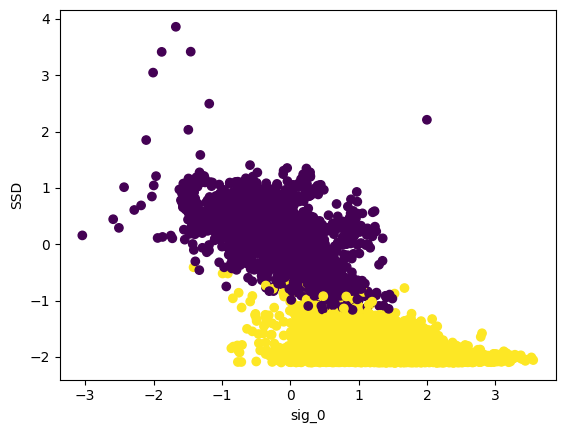

Text(0, 0.5, 'SSD')

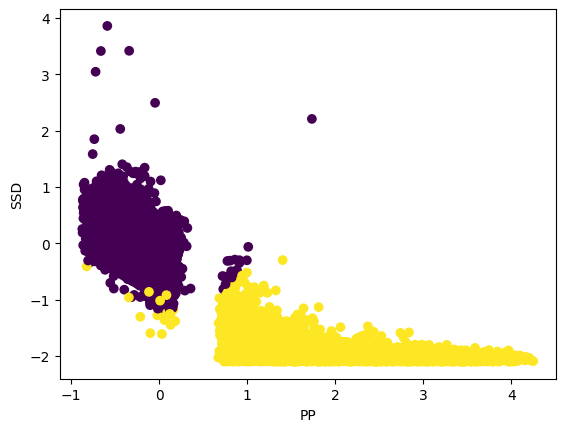

In [13]:
plt.scatter(data_cleaned[:,0],data_cleaned[:,1],c=clusters_gmm)
plt.xlabel("sig_0")
plt.ylabel("PP")
plt.show()
plt.scatter(data_cleaned[:,0],data_cleaned[:,2],c=clusters_gmm)
plt.xlabel("sig_0")
plt.ylabel("SSD")
plt.show()
plt.scatter(data_cleaned[:,1],data_cleaned[:,2],c=clusters_gmm)
plt.xlabel("PP")
plt.ylabel("SSD")

## Waveform Alignment Using Cross-Correlation

This code aligns waveforms in the cluster where `clusters_gmm == 0` by using cross-correlation.



Text(0.5, 1.0, 'Plot of 10 equally spaced functions where clusters_gmm = 0 (aligned)')

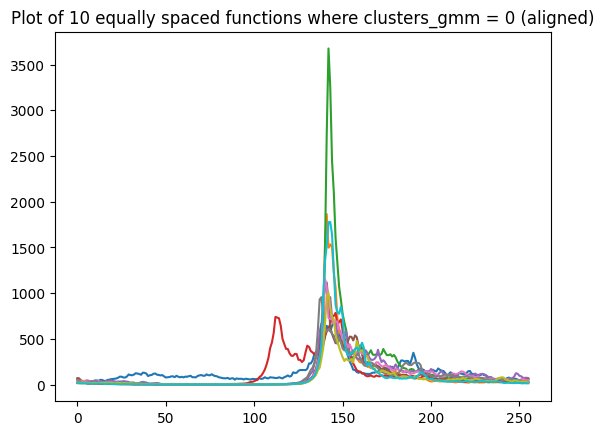

In [14]:
# Using clusters_gmm = 0 will give the waveform alignment for the sea ice
from scipy.signal import correlate

# Find the reference point (e.g., the peak)
reference_point_index = np.argmax(np.mean(waves_cleaned[clusters_gmm==0], axis=0))

# Calculate cross-correlation with the reference point
aligned_waves = []
for wave in waves_cleaned[clusters_gmm==0][::len(waves_cleaned[clusters_gmm == 0]) // 10]:
    correlation = correlate(wave, waves_cleaned[clusters_gmm==0][0])
    shift = len(wave) - np.argmax(correlation)
    aligned_wave = np.roll(wave, shift)
    aligned_waves.append(aligned_wave)

# Plot aligned waves
for aligned_wave in aligned_waves:
    plt.plot(aligned_wave)

plt.title('Plot of 10 equally spaced functions where clusters_gmm = 0 (aligned)')

Text(0.5, 1.0, 'Plot of 10 equally spaced functions where clusters_gmm = 1 (aligned)')

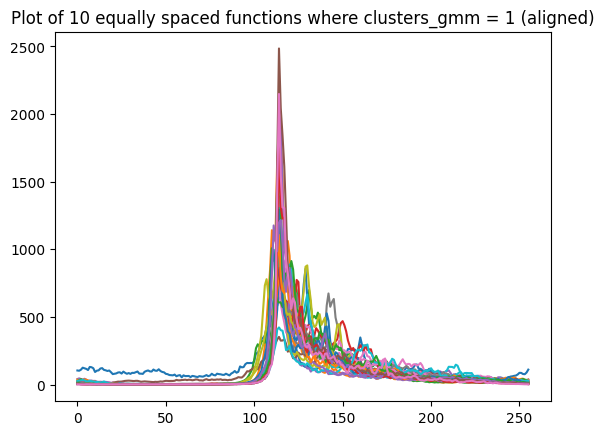

In [15]:
# Using clusters_gmm = 1 will give the waveform alignment for the leads
from scipy.signal import correlate

# Find the reference point (e.g., the peak)
reference_point_index = np.argmax(np.mean(waves_cleaned[clusters_gmm==1], axis=0))

# Calculate cross-correlation with the reference point
aligned_waves = []
for wave in waves_cleaned[clusters_gmm==0][::len(waves_cleaned[clusters_gmm == 1]) // 10]:
    correlation = correlate(wave, waves_cleaned[clusters_gmm==1][0])
    shift = len(wave) - np.argmax(correlation)
    aligned_wave = np.roll(wave, shift)
    aligned_waves.append(aligned_wave)

# Plot aligned waves
for aligned_wave in aligned_waves:
    plt.plot(aligned_wave)

plt.title('Plot of 10 equally spaced functions where clusters_gmm = 1 (aligned)')

## Compare with ESA data and create Confusion Matrix

> Add blockquote


In the ESA dataset, sea ice = 1 and lead = 2. Therefore, we need to subtract 1 from it so our predicted labels are comparable with the official product labels.

In [16]:
flag_cleaned_modified = flag_cleaned - 1

In [17]:
from sklearn.metrics import confusion_matrix, classification_report

true_labels = flag_cleaned_modified   # true labels from the ESA dataset
predicted_gmm = clusters_gmm          # predicted labels from GMM method

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_gmm)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Compute classification report
class_report = classification_report(true_labels, predicted_gmm)

# Print classification report
print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[8856   22]
 [  24 3293]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      8878
         1.0       0.99      0.99      0.99      3317

    accuracy                           1.00     12195
   macro avg       1.00      1.00      1.00     12195
weighted avg       1.00      1.00      1.00     12195

